In [3]:
pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Load libraries ライブラリの読み込み
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

# For preprocessing
# 前処理
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

# For models
# モデル
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# For evaluation
# 評価
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [18]:
# Participant to forecast
# 予測する参加者
USER = 'participant1'

# Collection dataset
# 予測するコレクション
# COLLECTION = '2-person'
COLLECTION = '10-person'

# Define train data path
# 学習データのパス
#TRAIN_DATA_PATH = f'/workspaces/ABC Challenge 2023 train dataset/{COLLECTION}'

# Define test data path
# テストデータのパス
#TEST_DATA_PATH = '/workspaces/ABC Challenge 2023 test dataset'

In [19]:
# Choose features 特徴量
# Garmin features Garminの特徴量
features = ['heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem',
            'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
# 追加の特徴量
features += ['timestamp_hour', 'timestamp_dayofweek',
             'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

# Normalize features
# 特徴量の正規化
normalize_features = features

# Metrics & Other Hyperparameters
# メトリクスとその他のハイパーパラメータ
SHIFT = 1
N_IN = 2   # t-2, t-1, t
N_OUT = 2  # t+1
RECORD_SIZE_PER_DAY = 96  # 60 minutes / 15 minutes * 24 hours = 96
FIGSIZE = (20, 7)
FIGSIZE_CM = (13, 7)

In [20]:
# Define test periods
# テスト期間の定義
test_horizons = {
  "participant1": ["2021-12-02 0:00", "2021-12-03 23:45"],
  "participant2": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant3": ["2021-11-25 0:00", "2021-11-26 23:45"],
  "participant4": ["2021-12-06 0:00", "2021-12-07 7:15"],
  "participant5": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant6": ["2021-12-06 0:00", "2021-12-07 23:45"],
  "participant7": ["2021-12-12 0:00", "2021-12-13 9:45"],
  "participant8": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant9": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant10": ["2021-12-23 0:00", "2021-12-24 23:45"],
}

# Convert test periods to DataFrame
# テスト期間をDataFrameに変換
test_horizons_df = pd.DataFrame(
  [[participant, test_start_date, test_end_date]
   for participant, (test_start_date, test_end_date) in test_horizons.items()],
  columns=['participant', 'test_start_date', 'test_end_date']
)

In [21]:
# Load participant's Excel file TRAIN SET
# 学習データの読み込み
dataset = pd.read_excel(f'D:\\UEL\\Disertation\\Parkinsons Disease\\Train Dataset\\combined_data.xlsx',
                        index_col="timestamp",
                        usecols=columns,
                        engine='openpyxl').query(f'participant == "{USER}"')

# Fill missing data with 0
# 欠損値を0で埋める
dataset.fillna(0, inplace=True)

# Filter by participant
# 参加者でフィルタリング
dataset = dataset.query(f'participant == "{USER}"').drop(
    columns=['participant'])

dataset.head()


,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency,timestamp_hour,timestamp_dayofweek,timestamp_hour_sin,timestamp_hour_cos,wearing_off
timestamp,,,,,,,,,,,,,,,,
2021-11-25 00:00:00,0.000000,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,-7.627160e-12,1.000000,0
2021-11-25 00:15:00,0.000000,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,6.540313e-02,0.997859,0
2021-11-25 00:30:00,43.419355,0,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,1.305262e-01,0.991445,0
2021-11-25 00:45:00,60.250000,0,12.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,1.950903e-01,0.980785,0
2021-11-25 01:00:00,10.600000,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,2.588190e-01,0.965926,0


In [22]:

# -----------------------------------------------------------------------------
# Load participant's Excel file TEST SET
# テストデータの読み込み
dataset_test = pd.read_excel(f'D:\\UEL\\Disertation\\Parkinsons Disease\\Test Dataset\\Jupyter\\combined_data.xlsx',
                             index_col="timestamp",
                             usecols=columns,
                             engine='openpyxl').query(f'participant == "{USER}"')

# Fill missing data with 0
# 欠損値を0で埋める
dataset_test.fillna(0, inplace=True)

# Filter by participant
# 参加者でフィルタリング
dataset_test = dataset_test.query(f'participant == "{USER}"').drop(
    columns=['participant'])

In [23]:
dataset_test.head(10)

,heart_rate,steps,stress_score,awake,deep,light,rem,nonrem_total,total,nonrem_percentage,sleep_efficiency,timestamp_hour,timestamp_dayofweek,timestamp_hour_sin,timestamp_hour_cos,wearing_off
timestamp,,,,,,,,,,,,,,,,
2021-12-02 00:00:00,-1.000000,0,-1.0,0,86,119,0,205,205,1,1.0,0,3,-6.641221e-12,1.000000,0.0
2021-12-02 00:15:00,-1.000000,0,-1.0,0,86,119,0,205,205,1,1.0,0,3,6.540313e-02,0.997859,0.0
2021-12-02 00:30:00,-1.000000,0,-1.0,0,86,119,0,205,205,1,1.0,0,3,1.305262e-01,0.991445,0.0
2021-12-02 00:45:00,-1.000000,0,-1.0,0,86,119,0,205,205,1,1.0,0,3,1.950903e-01,0.980785,0.0
2021-12-02 01:00:00,-1.000000,-1,-1.0,0,86,119,0,205,205,1,1.0,1,3,2.588190e-01,0.965926,0.0
2021-12-02 01:15:00,19.133333,15,7.4,0,86,119,0,205,205,1,1.0,1,3,3.214395e-01,0.946930,0.0
2021-12-02 01:30:00,86.050000,0,48.4,0,86,119,0,205,205,1,1.0,1,3,3.826834e-01,0.923880,0.0
2021-12-02 01:45:00,88.366667,0,55.0,0,86,119,0,205,205,1,1.0,1,3,4.422887e-01,0.896873,0.0
2021-12-02 02:00:00,79.650000,-1,14.4,0,86,119,0,205,205,1,1.0,2,3,5.000000e-01,0.866025,0.0


In [24]:
# Re-assign for convenience
# 便利のために再割り当て
train_df = dataset.copy()
test_df = dataset_test.copy()

In [25]:
# Convert series to supervised learning
# 時系列データを教師あり学習に変換
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  var_names = data.columns
  n_vars = len(var_names)
  df = pd.DataFrame(data)
  cols, names = list(), list()  # new column values, new columne names

  # input sequence (t-i, ... t-1)
  #   timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
  # 入力シーケンス (t-i, ... t-1)
  #   timesteps前 (例: n_in = 3, t-3, t-2, t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += list(
        map(lambda var_name: f'{var_name}(t-{i})', var_names)
    )

  # forecast sequence (t, t+1, ... t+n)
  #   timesteps after (e.g., n_out = 3, t, t+1, t+2)
  # 予測シーケンス (t, t+1, ... t+n)
  #   timesteps後 (例: n_out = 3, t, t+1, t+2)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += list(map(lambda var_name: f'{var_name}(t)', var_names))
    else:
      names += list(map(lambda var_name: f'{var_name}(t+{i})', var_names))

  # put it all together
  # 全てをまとめる
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  # NaN値を含む行を削除
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [26]:
# Split into X and y
# Xとyに分割
def split_x_y(df, target_columns, SHIFT=SHIFT, drop_wearing_off=True):
  # Drop extra columns i.e., (t+1), (t+2), (t+3), (t+4)
  # 余分な列を削除 (例: (t+1), (t+2), (t+3), (t+4))
  regex = r".*\(t\+[1-{SHIFT}]\)$"  # includes data(t)
  # regex = r"\(t(\+([1-{SHIFT}]))?\)$" # removes data(t)

  # Drop extra columns except target_columns
  # target_columns以外の余分な列を削除
  df.drop(
    [x for x in df.columns if re.search(regex, x) and x not in target_columns],
    axis=1, inplace=True
  )

  # Split into X and y
  # Xとyに分割
  y = df[target_columns].copy()
  X = df.drop(target_columns + [f'{TARGET_COLUMN}(t)'], axis=1)

  if drop_wearing_off:
    # Delete past wearing_off data, because it will not be provided in test data.
    #   Predicted past weaering_off can be used as feature, but make it yourself.
    # 過去のwearing_offデータを削除する。テストデータには含まれないため。
    #   予測された過去のwearing_offは特徴量として使用できますが、自分で作成してください。
    wearing_off_features = X.filter(like='wearing_off').columns
    X = X.drop(columns=wearing_off_features)

  return (X, y)

In [27]:
# Load submission file to get test data times
# テストデータの時間を取得するために提出ファイルを読み込む
submission_df = pd.read_csv(f'D:\\UEL\\Disertation\\Parkinsons Disease\\Test Dataset\\Test Dataset\\submission.csv',
                            index_col=0
                            ).query(f'participant == "{USER}"')
submission_df['Timestamp'] = pd.to_datetime(submission_df['Timestamp'])
submission_df['reframed_timestamp'] = pd.to_datetime(
  submission_df['reframed_timestamp']
)
submission_df.rename(columns={'Timestamp': 'timestamp'}, inplace=True)


def keep_forecast_times(full_test_data, submission_df):
  # Keep the test data times
  #   with the same participant & timestamp
  # テストデータの時間を保持する
  #   同じ参加者とタイムスタンプ
  return full_test_data.reset_index().merge(
    submission_df[['reframed_timestamp']],
    left_on=['timestamp'],
    right_on=['reframed_timestamp'],
    how='right'
  ).drop(columns='reframed_timestamp').set_index('timestamp')

In [28]:
submission_df.head(10)

,timestamp,reframed_timestamp,participant,final_wearing_off
0,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,NaN
1,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,NaN
2,2021-12-02 03:00:00,2021-12-02 02:45:00,participant1,NaN
3,2021-12-02 04:00:00,2021-12-02 03:45:00,participant1,NaN
4,2021-12-02 05:00:00,2021-12-02 04:45:00,participant1,NaN
5,2021-12-02 06:00:00,2021-12-02 05:45:00,participant1,NaN
6,2021-12-02 07:00:00,2021-12-02 06:45:00,participant1,NaN
7,2021-12-02 08:00:00,2021-12-02 07:45:00,participant1,NaN
8,2021-12-02 09:00:00,2021-12-02 08:45:00,participant1,NaN
9,2021-12-02 10:00:00,2021-12-02 09:45:00,participant1,NaN


In [29]:
# TRAIN SET
# n_in = 2 i.e., 30 minutes before (t-2, t-1, t)
# n_out = 2 i.e., 15 minutes after (t+1)
# Example:
#   t = 00:45:00
#   X = { 00:15:00, 00:30:00, 00:45:00 }
#   y = { 1:00:00 }

# トレーニングセット
# n_in = 2 例: 30分前 (t-2, t-1, t)
# n_out = 2 例: 15分後 (t+1)
# 例:
#   t = 00:45:00
#   X = { 00:15:00, 00:30:00, 00:45:00 }
#   y = { 1:00:00 }
reframed_train_df = series_to_supervised(train_df,
                                         n_in=N_IN,
                                         n_out=N_OUT,
                                         dropnan=True)

train_X, train_y = split_x_y(
    reframed_train_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])

display(train_y.head(5))
display(train_X.head(5))

,wearing_off(t+1)
timestamp,
2021-11-25 00:30:00,0.0
2021-11-25 00:45:00,0.0
2021-11-25 01:00:00,0.0
2021-11-25 01:15:00,0.0
2021-11-25 01:30:00,0.0


,heart_rate(t-2),steps(t-2),stress_score(t-2),awake(t-2),deep(t-2),light(t-2),rem(t-2),nonrem_total(t-2),total(t-2),nonrem_percentage(t-2),...,light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t)
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-25 00:30:00,0.000000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.130526,0.991445
2021-11-25 00:45:00,0.000000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.195090,0.980785
2021-11-25 01:00:00,43.419355,0.0,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.258819,0.965926
2021-11-25 01:15:00,60.250000,0.0,12.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.321439,0.946930
2021-11-25 01:30:00,10.600000,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.382683,0.923880


In [30]:
# TEST SET
# n_in = 2 i.e., 30 minutes before (t-2, t-1, t)
# n_out = 2 i.e., 15 minutes after (t+1)
# Example:
#   t = 00:45:00
#   X = { 00:15:00, 00:30:00, 00:45:00 }
#   y = { 1:00:00 }

# テストセット
# n_in = 2 例: 30分前 (t-2, t-1, t)
# n_out = 2 例: 15分後 (t+1)
# 例:
#   t = 00:45:00
#   t = 00:45:00
#   X = { 00:15:00, 00:30:00, 00:45:00 }
#   y = { 1:00:00 }
reframed_test_df = series_to_supervised(test_df,
                                        n_in=N_IN,
                                        n_out=N_OUT,
                                        dropnan=True)


# Keep only the test data times based on submission file
# 提出ファイルに基づいてテストデータの時間のみを保持する
tmp_df = keep_forecast_times(reframed_test_df,
                             submission_df=submission_df)

test_X, test_y = split_x_y(tmp_df, [f'{TARGET_COLUMN}(t+{N_OUT-1})'])

display(test_y.head(10))
display(test_X.head(10))

,wearing_off(t+1)
timestamp,
2021-12-02 00:45:00,0.0
2021-12-02 00:45:00,0.0
2021-12-02 00:45:00,0.0
2021-12-02 01:45:00,0.0
2021-12-02 01:45:00,0.0
2021-12-02 01:45:00,0.0
2021-12-02 02:45:00,0.0
2021-12-02 02:45:00,0.0
2021-12-02 02:45:00,0.0


,heart_rate(t-2),steps(t-2),stress_score(t-2),awake(t-2),deep(t-2),light(t-2),rem(t-2),nonrem_total(t-2),total(t-2),nonrem_percentage(t-2),...,light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t)
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-02 00:45:00,-1.000000,0.0,-1.0,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,0,3,0.195090,0.980785
2021-12-02 00:45:00,-1.000000,0.0,-1.0,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,0,3,0.195090,0.980785
2021-12-02 00:45:00,-1.000000,0.0,-1.0,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,0,3,0.195090,0.980785
2021-12-02 01:45:00,19.133333,15.0,7.4,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,1,3,0.442289,0.896873
2021-12-02 01:45:00,19.133333,15.0,7.4,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,1,3,0.442289,0.896873
2021-12-02 01:45:00,19.133333,15.0,7.4,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,1,3,0.442289,0.896873
2021-12-02 02:45:00,69.800000,0.0,3.6,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,2,3,0.659346,0.751840
2021-12-02 02:45:00,69.800000,0.0,3.6,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,2,3,0.659346,0.751840
2021-12-02 02:45:00,69.800000,0.0,3.6,0.0,86.0,119.0,0.0,205.0,205.0,1.0,...,119,0,205,205,1,1.0,2,3,0.659346,0.751840


In [31]:

# MinMaxScaler was used but feel free to change
# MinMaxScalerを使用しましたが、自由に変更してください
scaler = MinMaxScaler(feature_range=(0, 1))

# TRAIN SET
# トレーニングセット
train_X_scaled = scaler.fit_transform(train_X)
train_X_scaled = pd.DataFrame(train_X_scaled,
                              columns=train_X.columns,
                              index=train_X.index)

# TEST SET
# テストセット
test_X_scaled = scaler.fit_transform(test_X)
test_X_scaled = pd.DataFrame(test_X_scaled,
                             columns=test_X.columns,
                             index=test_X.index)

In [32]:
# Normalizer was used but feel free to change
# 正規化器を使用しましたが、自由に変更してください
normalizer = Normalizer()

# TRAIN SET
# トレーニングセット
train_X_scaled_normalized = normalizer.fit_transform(train_X_scaled)
train_X_scaled_normalized = pd.DataFrame(train_X_scaled_normalized,
                                         columns=train_X.columns,
                                         index=train_X.index)

# TEST SET
# テストセット
test_X_scaled_normalized = normalizer.fit_transform(test_X_scaled)
test_X_scaled_normalized = pd.DataFrame(test_X_scaled_normalized,
                                        columns=test_X.columns,
                                        index=test_X.index)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:

# Keep original processed data for later use
# 以降の使用のために元の処理済みデータを保持する
original_train_X_scaled_normalized = train_X_scaled_normalized.copy()
original_train_X = train_X.copy()
original_train_y = train_y.copy()
original_test_X = test_X.copy()

In [35]:
# Split train set to train and validation set for participant's internal validation
# 参加者の内部検証のためにトレーニングセットをトレーニングセットと検証セットに分割する
train_X, val_X, train_y, val_y = train_test_split(original_train_X_scaled_normalized,
                                                  original_train_y,
                                                  test_size=0.33,
                                                  random_state=4)
test_X = test_X_scaled_normalized.copy()

In [37]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


# Modeling using LightGBM

In [38]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(random_state=4, n_estimators=1000)

In [39]:
lgb_model.fit(train_X, train_y)

C:\Users\asaif\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\asaif\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_estimators=1000, random_state=4)

In [40]:
forecasts = lgb_model.predict(val_X)
forecasts_proba = lgb_model.predict_proba(val_X)[:, 1]
forecasts_output = pd.DataFrame({
    'participant': [USER] * len(forecasts),
    'forecasted_wearing_off': forecasts,
    'forecasted_wearing_off_probability': forecasts_proba,
    'ground_truth': val_y.values.flatten()
}, index=val_X.index)
forecasts_output.sort_index(inplace=True)


In [41]:
forecasts_test = lgb_model.predict(test_X)
forecasts_proba_test = lgb_model.predict_proba(test_X)[:, 1]
forecasts_output_test = pd.DataFrame({
    'participant': [USER] * len(forecasts_test),
    'forecasted_wearing_off': forecasts_test,
    'forecasted_wearing_off_probability': forecasts_proba_test,
    'ground_truth': test_y.values.flatten()
}, index=test_X.index)
forecasts_output_test.sort_index(inplace=True)


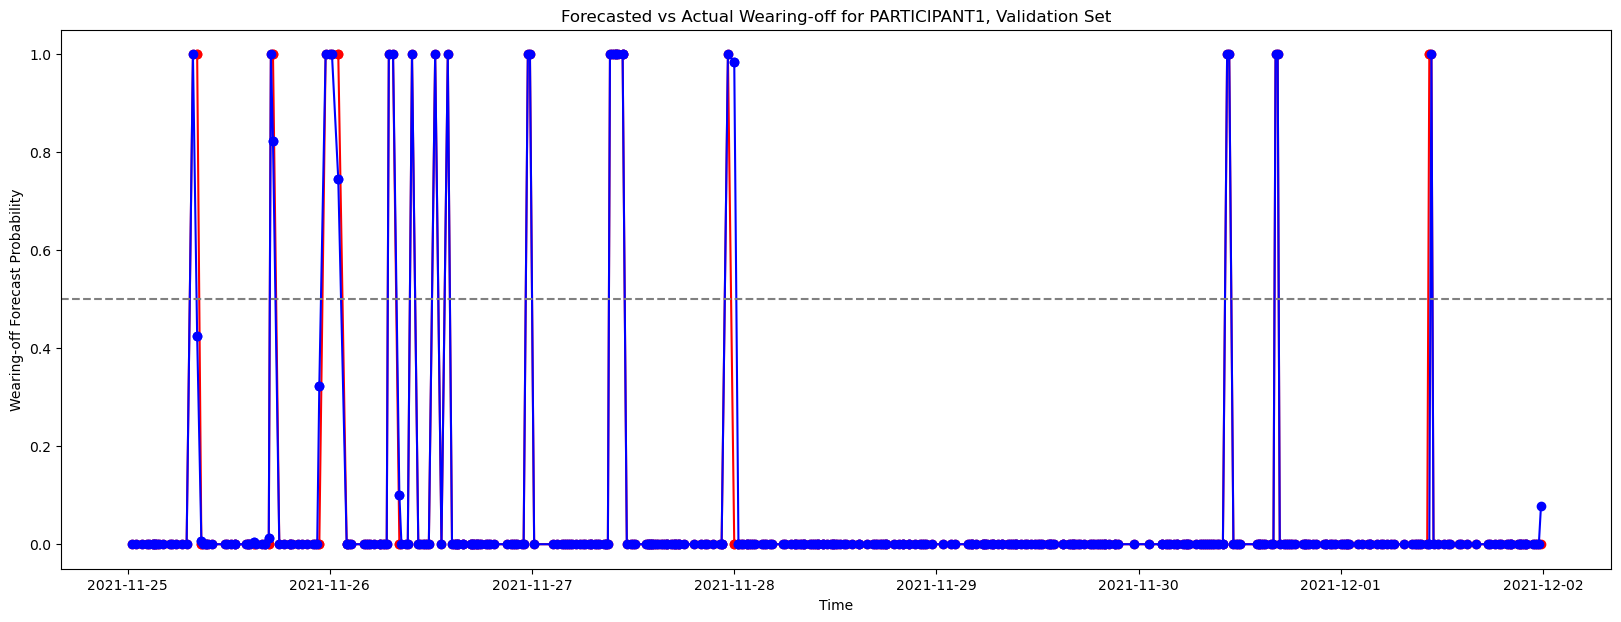

In [42]:
plt.figure(figsize=FIGSIZE)
plt.plot(forecasts_output.ground_truth,
         label='actual', color='red', marker='o')
plt.plot(forecasts_output.forecasted_wearing_off_probability,
         label='predicted', color='blue', marker='o')
plt.axhline(0.5, linestyle='--', color='gray')
plt.ylabel('Wearing-off Forecast Probability')
plt.xlabel('Time')
plt.title(f"Forecasted vs Actual Wearing-off for {USER.upper()}, Validation Set")
plt.show()


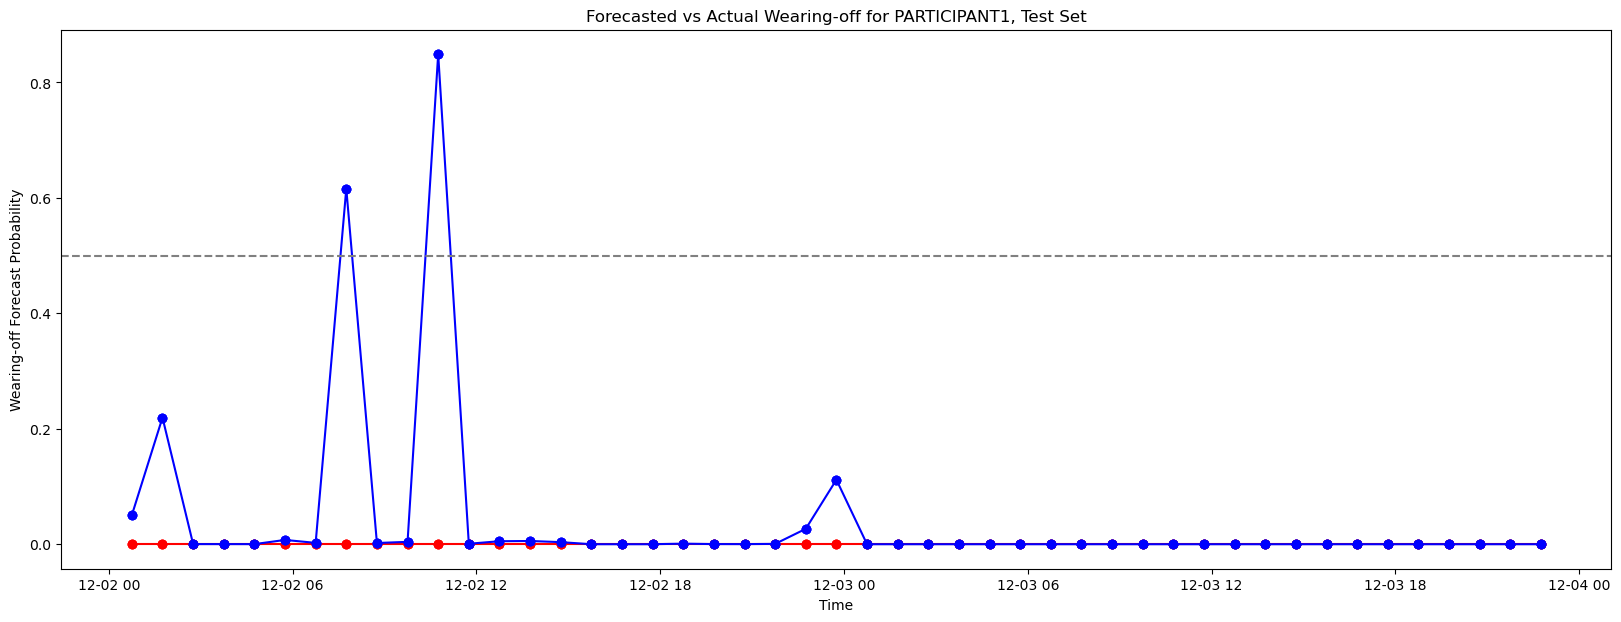

In [43]:
plt.figure(figsize=FIGSIZE)
plt.plot(forecasts_output_test.ground_truth,
         label='actual', color='red', marker='o')
plt.plot(forecasts_output_test.forecasted_wearing_off_probability,
         label='predicted', color='blue', marker='o')
plt.axhline(0.5, linestyle='--', color='gray')
for i in forecasts_output_test.index:
    if pd.Timestamp(i).minute == 0:
        plt.axvline(i, linestyle='--', color='gray')
plt.ylabel('Wearing-off Forecast Probability')
plt.xlabel('Time')
plt.title(f"Forecasted vs Actual Wearing-off for {USER.upper()}, Test Set")
plt.show()


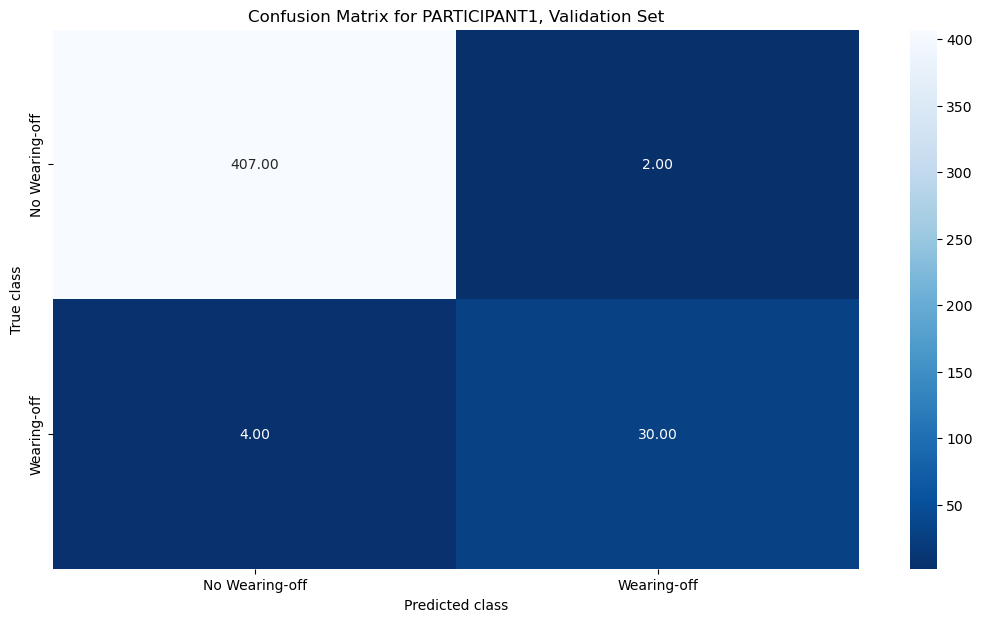

C:\Users\asaif\AppData\Local\Temp\ipykernel_31560\1310320063.py:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = forecasts_output.corr()


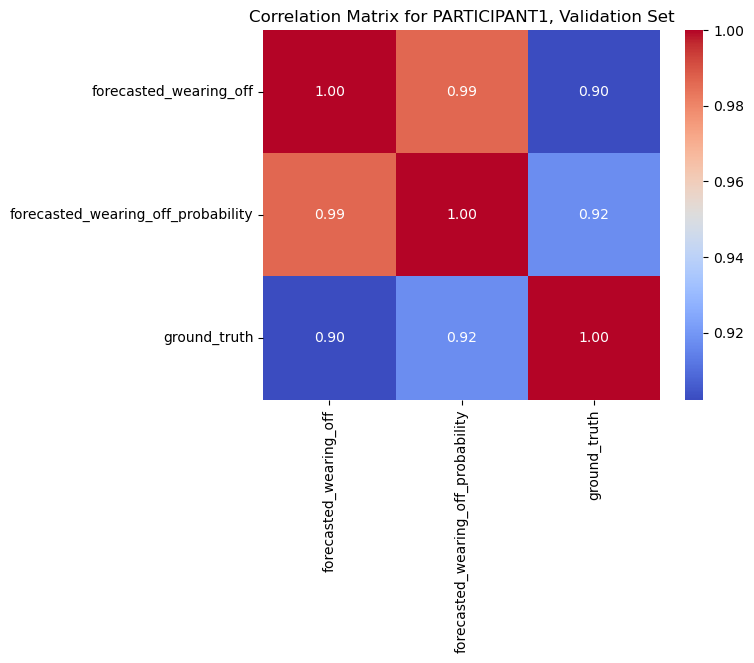

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set labels for confusion matrix
labels = ['No Wearing-off', 'Wearing-off']

# Calculate confusion matrix
conf_matrix = confusion_matrix(forecasts_output.ground_truth,
                               forecasts_output.forecasted_wearing_off)

# Plot confusion matrix
plt.figure(figsize=FIGSIZE_CM)
sns.heatmap(conf_matrix,
            xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='Blues_r')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title(f"Confusion Matrix for {USER.upper()}, Validation Set")
plt.show()

# Calculate correlation matrix
corr_matrix = forecasts_output.corr()

# Plot correlation matrix
#plt.figure(figsize=10)
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,
            annot=True, fmt=".2f", cmap='coolwarm')
plt.title(f"Correlation Matrix for {USER.upper()}, Validation Set")
plt.show()


In [45]:
# Make forecasts for validation set
# 検証セットの予測を作成する
forecasts = lgb_model.predict(
  val_X
)

# Get the probability for 1s class
# 1sクラスの確率を取得する
forecasts_proba = lgb_model.predict_proba(
  val_X
)[:, 1]

# Transform as dataframe with timestamp
# タイムスタンプ付きのデータフレームに変換する
forecasts_output = pd.DataFrame(
  {
    'participant': [USER] * len(forecasts),
    'forecasted_wearing_off': forecasts,
    'forecasted_wearing_off_probability': forecasts_proba,
    'ground_truth': val_y.values.flatten(),
  },
  index=val_X.index
)

# Sort by timestamp
# タイムスタンプでソートする
forecasts_output.sort_index(inplace=True)

In [46]:
# Make forecasts for test set and submission
# テストセットと提出の予測を作成する
forecasts_test =lgb_model.predict(
  test_X
)

# Get the probability for 1s class
# 1sクラスの確率を取得する
forecasts_proba_test = lgb_model.predict_proba(
  test_X
)[:, 1]

# Transform as dataframe with timestamp
# タイムスタンプ付きのデータフレームに変換する
forecasts_output_test = pd.DataFrame(
  {
    'participant': [USER] * len(forecasts_test),
    'forecasted_wearing_off': forecasts_test,
    'forecasted_wearing_off_probability': forecasts_proba_test,
    'ground_truth': test_y.values.flatten(),
  },
  index=test_X.index
)

# Sort by timestamp
# タイムスタンプでソートする
forecasts_output_test.sort_index(inplace=True)

In [47]:
# Calculate fpr, tpr, thresholds
# fpr、tpr、閾値を計算する
fpr, tpr, thresholds = metrics.roc_curve(forecasts_output.sort_index().ground_truth,
                                         forecasts_output.sort_index().forecasted_wearing_off_probability)

######################
# Evaluate predictions with f1 score, recall, precision, accuracy, auc-roc, auc-prc
# f1スコア、リコール、精度、正解率、auc-roc、auc-prcで予測を評価する
model_metric_scores = pd.DataFrame(
  [
    metrics.f1_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.recall_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.precision_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.accuracy_score(
      forecasts_output.ground_truth,
      forecasts_output.forecasted_wearing_off),
    metrics.auc(fpr, tpr),
    metrics.average_precision_score(
      forecasts_output.sort_index().ground_truth,
      forecasts_output.sort_index().forecasted_wearing_off_probability)
  ],
  index=['f1 score', 'recall', 'precision', 'accuracy', 'auc-roc', 'auc-prc'],
  columns=['metrics']
).T.round(3).assign(participant=USER)
model_metric_scores.set_index(['participant'], inplace=True)

######################
# Generate classification report
# 分類レポートを生成する
model_classification_report = pd.DataFrame(
  classification_report(
    forecasts_output.ground_truth,
    forecasts_output.forecasted_wearing_off,
    output_dict=True
  )
).T.round(3).assign(participant=USER)
# Set index's name to 'classification report'
# インデックスの名前を「分類レポート」に設定する
model_classification_report.index.name = 'classification report'

# Remove row that has 'accuracy' as index
# インデックスに「accuracy」がある行を削除する
model_classification_report = model_classification_report.drop(
  ['accuracy'], axis=0)

model_classification_report = model_classification_report.reset_index()
model_classification_report.set_index(
    ['participant', 'classification report'], inplace=True)

model_metric_scores.reset_index(inplace=True)
model_classification_report.reset_index(inplace=True)

display(model_metric_scores)
display(model_classification_report)

,participant,f1 score,recall,precision,accuracy,auc-roc,auc-prc
0,participant1,0.909,0.882,0.938,0.986,0.997,0.973


,participant,classification report,precision,recall,f1-score,support
0,participant1,0.0,0.990,0.995,0.993,409.0
1,participant1,1.0,0.938,0.882,0.909,34.0
2,participant1,macro avg,0.964,0.939,0.951,443.0
3,participant1,weighted avg,0.986,0.986,0.986,443.0


In [48]:
# Load submission file as template
# 提出ファイルをテンプレートとしてロードする
template_df = pd.read_csv(f'D:\\UEL\\Disertation\\Parkinsons Disease\\Test Dataset\\Test Dataset\\submission.csv', index_col=0)
template_df['Timestamp'] = pd.to_datetime(template_df['Timestamp'])
template_df['reframed_timestamp'] = pd.to_datetime(
    template_df['reframed_timestamp'])
template_df.head(5)

,Timestamp,reframed_timestamp,participant,final_wearing_off
0,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,NaN
1,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,NaN
2,2021-12-02 03:00:00,2021-12-02 02:45:00,participant1,NaN
3,2021-12-02 04:00:00,2021-12-02 03:45:00,participant1,NaN
4,2021-12-02 05:00:00,2021-12-02 04:45:00,participant1,NaN


In [49]:
# Merge template with forecasts_output_test
# テンプレートとforecasts_output_testをマージする
output_df = template_df.merge(
  forecasts_output_test.reset_index(),
  left_on=['reframed_timestamp', 'participant'],
  right_on=['timestamp', 'participant']
)[
  list(template_df.columns)[:-1] + ['forecasted_wearing_off']
].rename(
  columns={'forecasted_wearing_off': 'final_wearing_off'}
)
output_df.head(5)

,Timestamp,reframed_timestamp,participant,final_wearing_off
0,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,0.0
1,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,0.0
2,2021-12-02 01:00:00,2021-12-02 00:45:00,participant1,0.0
3,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,0.0
4,2021-12-02 02:00:00,2021-12-02 01:45:00,participant1,0.0


We Get best 
F1 score = 0.909
recall score = 0.882
precision score = 0.938	
accuracy score = 0.986

In [50]:
import sys
sys.version_info

sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)

In [51]:
import sys
print(sys.version)

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]


# Deep Learning "Keras" 


In [52]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

In [4]:
pip install tensorflow

     -------------------------------------- 276.5/276.5 MB 6.6 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 8.0 MB/s eta 0:00:00
     ------------------------------------- 422.5/422.5 kB 13.3 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 11.8 MB/s eta 0:00:00
     -------------------------------------- 440.8/440.8 kB 9.2 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     --------------------------------------- 24.4/24.4 MB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
     ------------------------------------- 181.8/181.8 kB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 151.7/151.7 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated 

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_val_scaled = scaler.transform(val_X)
X_test_scaled = scaler.transform(test_X)

In [68]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(train_X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [69]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [71]:
model.fit(X_train_scaled, train_y, epochs=10, batch_size=32, validation_data=(X_val_scaled, val_y))


Epoch 1/10
29/29 [==============================] - 1s 16ms/step - loss: 0.3719 - accuracy: 0.8797 - val_loss: 0.2479 - val_accuracy: 0.9233
Epoch 2/10
29/29 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9198 - val_loss: 0.2347 - val_accuracy: 0.9233
Epoch 3/10
29/29 [==============================] - 0s 3ms/step - loss: 0.2067 - accuracy: 0.9220 - val_loss: 0.2216 - val_accuracy: 0.9255
Epoch 4/10
29/29 [==============================] - 0s 4ms/step - loss: 0.1926 - accuracy: 0.9254 - val_loss: 0.2119 - val_accuracy: 0.9187
Epoch 5/10
29/29 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.9254 - val_loss: 0.2167 - val_accuracy: 0.9142
Epoch 6/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1754 - accuracy: 0.9343 - val_loss: 0.1980 - val_accuracy: 0.9255
Epoch 7/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1608 - accuracy: 0.9332 - val_loss: 0.1894 - val_accuracy: 0.9255
Epoch 8/10
29/29 [=

In [74]:
loss, accuracy = model.evaluate(X_test_scaled, test_y)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

5/5 [==============================] - 0s 3ms/step - loss: 0.1621 - accuracy: 1.0000
Test Loss: 0.16205914318561554
Test Accuracy: 1.0


Epoch 1/10
29/29 [==============================] - 0s 8ms/step - loss: 0.1316 - accuracy: 0.9432 - val_loss: 0.1695 - val_accuracy: 0.9300
Epoch 2/10
29/29 [==============================] - 0s 5ms/step - loss: 0.1220 - accuracy: 0.9443 - val_loss: 0.1788 - val_accuracy: 0.9187
Epoch 3/10
29/29 [==============================] - 0s 9ms/step - loss: 0.1190 - accuracy: 0.9499 - val_loss: 0.1630 - val_accuracy: 0.9278
Epoch 4/10
29/29 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.9543 - val_loss: 0.1502 - val_accuracy: 0.9413
Epoch 5/10
29/29 [==============================] - 0s 9ms/step - loss: 0.1223 - accuracy: 0.9499 - val_loss: 0.1614 - val_accuracy: 0.9278
Epoch 6/10
29/29 [==============================] - 0s 12ms/step - loss: 0.1060 - accuracy: 0.9610 - val_loss: 0.1468 - val_accuracy: 0.9413
Epoch 7/10
29/29 [==============================] - 0s 11ms/step - loss: 0.0970 - accuracy: 0.9666 - val_loss: 0.1490 - val_accuracy: 0.9368
Epoch 8/10
29/29 [

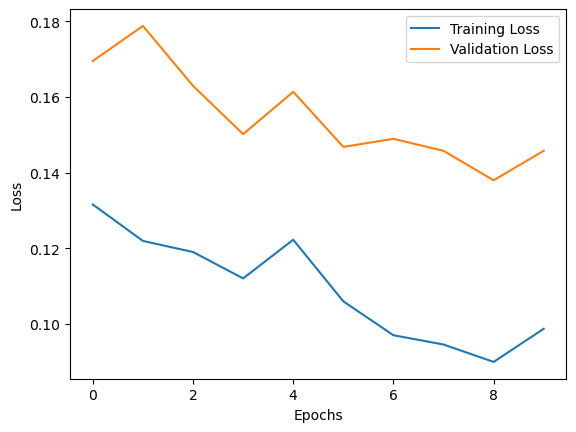

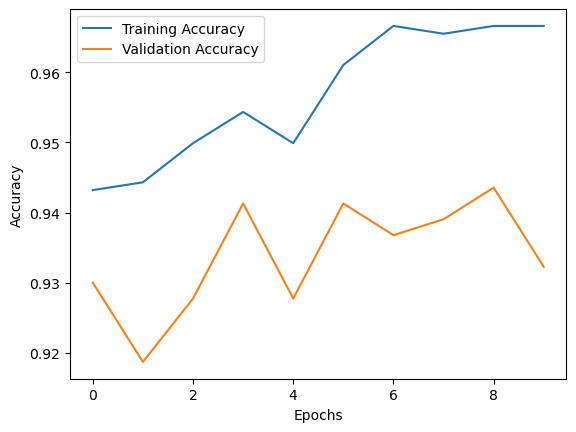

In [77]:
# Train the model and keep track of the training history
history = model.fit(X_train_scaled, train_y, epochs=10, batch_size=32, validation_data=(X_val_scaled, val_y))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Dont Run Below Part

In [88]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Assuming you have input sequences in X and corresponding labels in y

# Preprocess the data



In [89]:
# Convert sequences to fixed length and pad if necessary
max_sequence_length = 100  # Maximum length of input sequences
train_X = pad_sequences(train_X, maxlen=max_sequence_length)
train_Y = pad_sequences(train_Y, maxlen=max_sequence_length)

ValueError: invalid literal for int() with base 10: 'heart_rate(t-2)'

In [80]:
reframed_train_df['heart_rate(t-2)'] = pd.to_numeric(reframed_train_df['heart_rate(t-2)'], errors='coerce')

In [86]:
print(reframed_train_df['heart_rate(t-2)'].dtype)

int64


In [85]:
import re

# Assuming your data is stored in a DataFrame called 'df'
reframed_train_df['heart_rate(t-2)'] = reframed_train_df['heart_rate(t-2)'].apply(lambda x: re.sub('[^0-9]', '', str(x)))
reframed_train_df['heart_rate(t-2)'] = pd.to_numeric(reframed_train_df['heart_rate(t-2)'], errors='coerce')

In [96]:
import torch
import pandas as pd

# Assuming you have a pandas DataFrame called 'df'
# Extract the values from the DataFrame
data = train_X.values

# Convert the values to a torch.Tensor
tensor_data = torch.tensor(data)


In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have input sequences in X and corresponding labels in y

# Preprocess the data

# Convert sequences to fixed length and pad if necessary
max_sequence_length = 100  # Maximum length of input sequences
train_X = [torch.tensor(seq) for seq in data]
train_X = nn.utils.rnn.pad_sequence(train_X, batch_first=True)
test_X = [torch.tensor(seq) for seq in test_X]
test_X = nn.utils.rnn.pad_sequence(test_X, batch_first=True)

# Convert labels to tensors
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
test_y = label_encoder.transform(test_y)
y_train = torch.tensor(y_train)
test_y = torch.tensor(test_y)

# Create PyTorch DataLoader
train_data = TensorDataset(train_X, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = output[:, -1, :]  # Get the last time step output
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

# Set the hyperparameters
vocab_size = 10000 
embedding_dim = 100
hidden_dim = 128
num_epochs = 10

# Create the model instance
model = RNNModel(vocab_size, embedding_dim, hidden_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train the model
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

# Evaluate the model on the testing set
with torch.no_grad():
    model.eval()
    test_outputs = model(test_X)
    test_outputs = test_outputs.squeeze()
    test_predictions = torch.round(test_outputs)
    test_accuracy = (test_predictions == test_y).sum().item() / len(test_y)

print('Test Accuracy:', test_accuracy)


TypeError: new(): invalid data type 'str'